# Analysis of results

Packages

In [1]:
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.lines import Line2D
from pathlib import Path

BASE_DIR = Path(os.path.abspath(''))
os.chdir(BASE_DIR)
print(f'Working directory: {os.getcwd()}')

Working directory: c:\Users\jespe\Documents\GitHub_local\ARFusion


### Slide 9 - Overall accuracy vs data imbalance

In [2]:
results_mediumPT = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_mediumPT_0.5_0.9', 'results.pkl'))
results_naive = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_naive_0.5_0.9', 'results.pkl'))

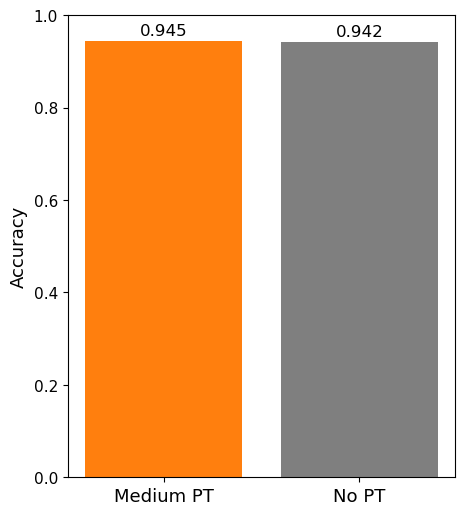

In [3]:
results_dicts = [results_mediumPT, results_naive]
model_names = ['Medium PT', 'No PT']
best_epochs = [results['best_epoch'] for results in results_dicts]
val_accs = [results_dicts[i]['val_accs'][best_epochs[i]] for i in range(len(results_dicts))]

fig, ax = plt.subplots(figsize=(5, 6))
bars = ax.bar(model_names, val_accs, color=['tab:orange', 'tab:gray'])
ax.bar_label(bars, fmt='%.3f', padding=2, fontsize=12)
ax.set_ylabel('Accuracy', fontsize=13)
ax.tick_params(axis='y', labelsize=11)
ax.tick_params(axis='x', labelsize=13)
ax.set_ylim(0, 1)
plt.savefig(os.path.join(BASE_DIR, 'results', 'halftime_figs', 'accs_wo_distr.png'), bbox_inches='tight', dpi=300, transparent=True)
plt.show()

In [4]:
ds_NCBI = pd.read_pickle(os.path.join(BASE_DIR, 'data', 'NCBI.pkl'))
ds_MM = ds_NCBI[ds_NCBI['num_ab'] > 0].reset_index(drop=True)
ds_MM['num_S'] = ds_MM['phenotypes'].apply(lambda x: len([p for p in x if p.endswith('S')]))
ds_MM['num_R'] = ds_MM['phenotypes'].apply(lambda x: len([p for p in x if p.endswith('R')]))
assert ds_MM['num_S'].sum() + ds_MM['num_R'].sum() == ds_MM['num_ab'].sum()

Fraction of S: 0.7673574872024254
Fraction of R: 0.23264251279757467


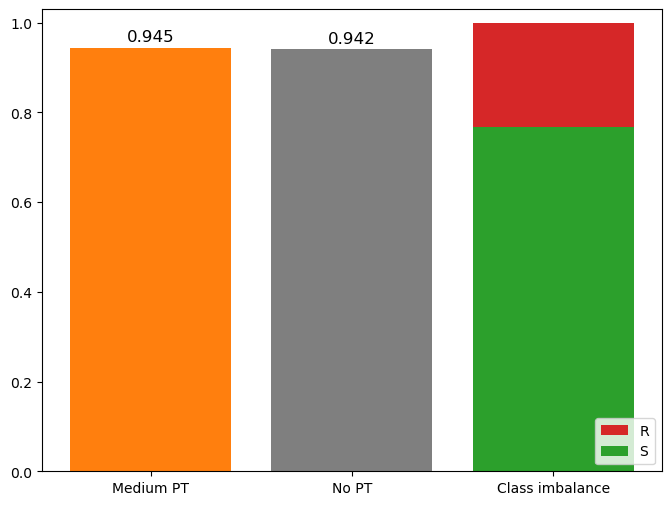

In [5]:
results_dicts = [results_mediumPT, results_naive]
model_names = ['Medium PT', 'No PT']
best_epochs = [results['best_epoch'] for results in results_dicts]
val_accs = [results_dicts[i]['val_accs'][best_epochs[i]] for i in range(len(results_dicts))]

frac_S = ds_MM['num_S'].sum() / ds_MM['num_ab'].sum()
frac_R = ds_MM['num_R'].sum() / ds_MM['num_ab'].sum()

print(f'Fraction of S: {frac_S}')
print(f'Fraction of R: {frac_R}')

fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(model_names, val_accs, color=['tab:orange', 'tab:gray'])
bar1 = ax.bar('Class imbalance', [frac_R], bottom=[frac_S], color='tab:red', label='R')
bar2 = ax.bar('Class imbalance', [frac_S], color='tab:green', label='S')
ax.bar_label(bars, fmt='%.3f', padding=2, fontsize=12)
ax.set_ylim(0, 1.03)
plt.legend(loc='lower right')
plt.savefig(os.path.join(BASE_DIR, 'results', 'halftime_figs', 'accs_vs_distr.png'), bbox_inches='tight', dpi=300, transparent=True)
plt.show()

### Slide 11 - Isolate accuracy at different masking probabilities

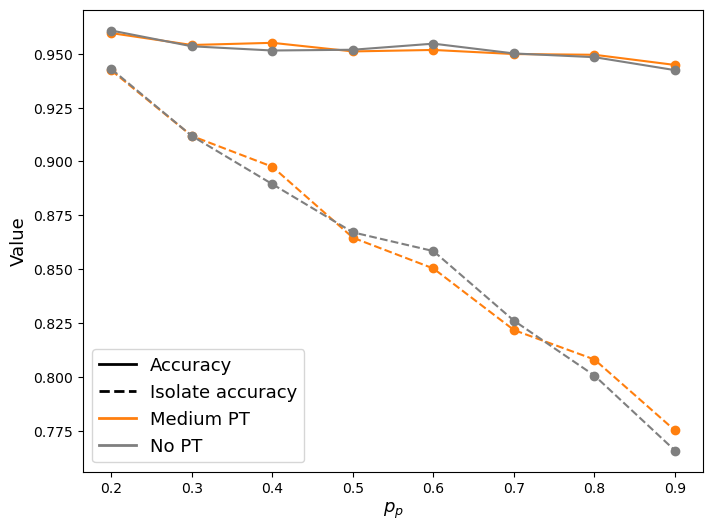

In [6]:
mask_probs = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
medium_accs = []
medium_iso_accs = []
naive_accs = []
naive_iso_accs = []
for i in range(len(mask_probs)):
    medium_results = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', f'FT_mediumPT_0.5_{mask_probs[i]}', 'results.pkl'))
    best_epoch = medium_results['best_epoch']
    medium_accs.append(medium_results['val_accs'][best_epoch])
    medium_iso_accs.append(medium_results['val_iso_accs'][best_epoch])
    
    naive_results = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', f'FT_naive_0.5_{mask_probs[i]}', 'results.pkl'))
    best_epoch = naive_results['best_epoch']
    naive_accs.append(naive_results['val_accs'][best_epoch])
    naive_iso_accs.append(naive_results['val_iso_accs'][best_epoch])

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(mask_probs, medium_accs, "-o", color='tab:orange', label='Medium PT')
ax.plot(mask_probs, medium_iso_accs, "--o",  color='tab:orange', label='Medium PT (iso_acc)')
ax.plot(mask_probs, naive_accs, "-o", color='tab:gray', label='No PT')
ax.plot(mask_probs, naive_iso_accs, "--o", color='tab:gray', label='No PT (iso_acc)')
ax.set_xlabel(r'$p_p$', fontsize=13)
ax.set_ylabel('Value', fontsize=13)

acc_line = Line2D([0], [0], color='black', linestyle='-', label='Accuracy', lw=2)
iso_acc_line = Line2D([0], [0], color='black', linestyle='--', label='Isolate accuracy', lw=2)
medium_line = Line2D([0], [0], color='tab:orange', linestyle='-', label='Medium PT', lw=2)
naive_line = Line2D([0], [0], color='tab:gray', linestyle='-', label='No PT', lw=2)
ax.legend(handles=[acc_line, iso_acc_line, medium_line, naive_line], fontsize=13)
plt.savefig(os.path.join(BASE_DIR, 'results', 'halftime_figs', 'accs_vs_mask.png'), bbox_inches='tight', dpi=300, transparent=True)
plt.show()

### Slide 12 - Isolate accuracy against number/share of antibiotics masked


In [7]:
results_medium = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_mediumPT_0.5_0.9', 'results.pkl'))
results_naive = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_naive_0.5_0.9', 'results.pkl'))
medium_iso_stats = results_medium['val_iso_stats']
naive_iso_stats = results_naive['val_iso_stats']
medium_iso_stats['num_ab'] = medium_iso_stats['num_ab'].astype(int)
naive_iso_stats['num_ab'] = naive_iso_stats['num_ab'].astype(int)

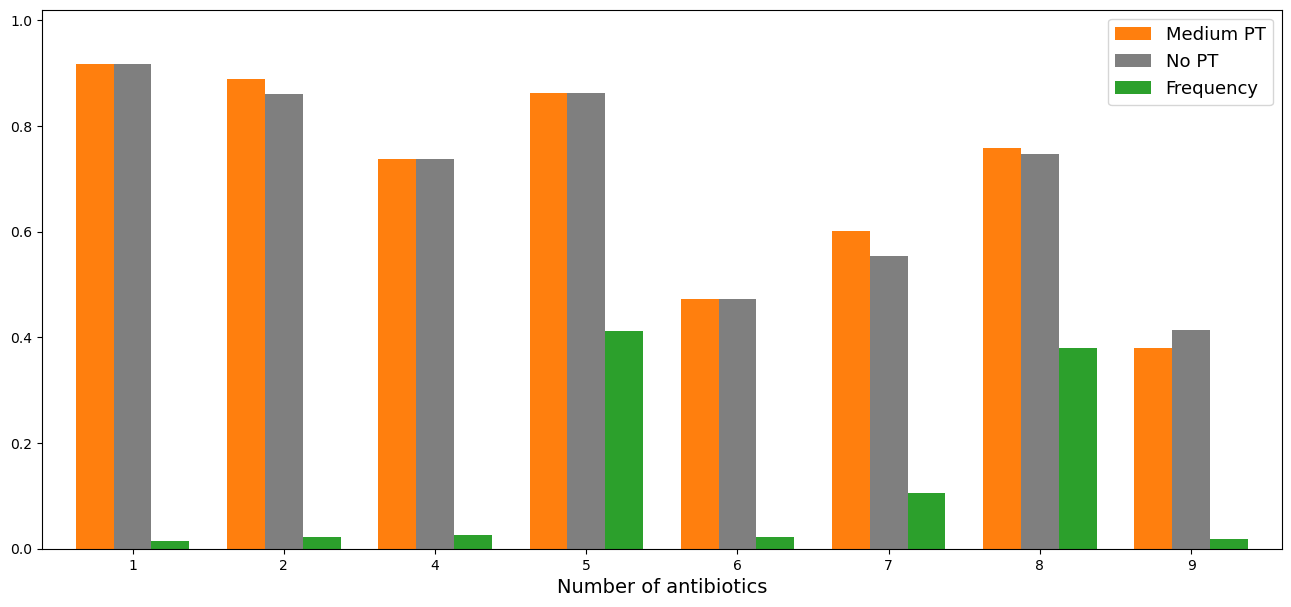

In [8]:
df_tmp = medium_iso_stats.groupby('num_ab').agg({'all_correct': ['mean', 'count']})
df_tmp.columns = ['accuracy', 'count']
df_tmp_naive = naive_iso_stats.groupby('num_ab').agg({'all_correct': ['mean', 'count']})
df_tmp_naive.columns = ['accuracy', 'count']
df_tmp = df_tmp[df_tmp['count'] > 20]
df_tmp_naive = df_tmp_naive[df_tmp_naive['count'] > 20]
df_tmp['share'] = df_tmp['count'] / df_tmp['count'].sum()

fig, ax = plt.subplots(figsize=(16, 7))
ind = np.arange(df_tmp.shape[0])
bar_width = 0.25
bar1 = ax.bar(ind - bar_width, df_tmp['accuracy'], width=bar_width, color='tab:orange', label='Medium PT')
bar2 = ax.bar(ind, df_tmp_naive['accuracy'], width=bar_width, color='tab:gray', label='No PT')
bar3 = ax.bar(ind + bar_width, df_tmp['share'], width=bar_width, color='tab:green', label='Frequency')
# ax.bar_label(bar1, fmt='%.3f', padding=1, fontsize=8)
# ax.bar_label(bar2, fmt='%.3f', padding=1, fontsize=8)

ax.set_xlabel('Number of antibiotics', fontsize=14)
ax.set_ylim(0, 1.02)
ax.set_xlim(-0.6, df_tmp.shape[0] - 0.4)
ax.set_xticks(ind)
ax.set_xticklabels(df_tmp.index)

plt.legend(loc='upper right', fontsize=13)
plt.show()

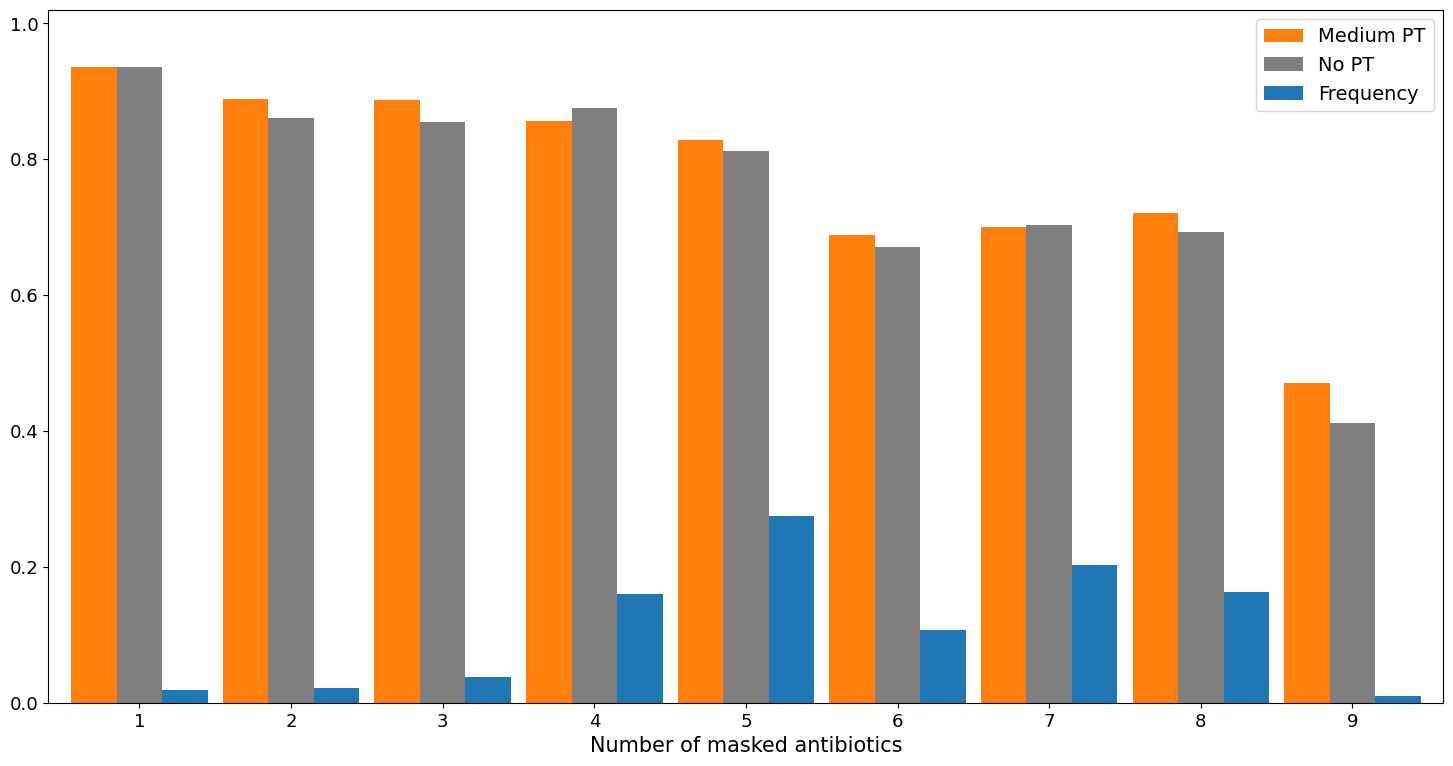

In [9]:
df_tmp = medium_iso_stats.groupby('num_masked').agg({'all_correct': ['mean', 'count']})
df_tmp.columns = ['accuracy', 'count']
df_tmp_naive = naive_iso_stats.groupby('num_masked').agg({'all_correct': ['mean', 'count']})
df_tmp_naive.columns = ['accuracy', 'count']
df_tmp = df_tmp[df_tmp['count'] > 10]
df_tmp_naive = df_tmp_naive[df_tmp_naive['count'] > 10]
df_tmp['share'] = df_tmp['count'] / df_tmp['count'].sum()

fig, ax = plt.subplots(figsize=(18, 9))
ind = np.arange(df_tmp.shape[0])
bar_width = 0.3
bar1 = ax.bar(ind - bar_width, df_tmp['accuracy'], width=bar_width, color='tab:orange', label='Medium PT')
bar2 = ax.bar(ind, df_tmp_naive['accuracy'], width=bar_width, color='tab:gray', label='No PT')
bar3 = ax.bar(ind + bar_width, df_tmp['share'], width=bar_width, color='tab:blue', label='Frequency')
# ax.bar_label(bar1, fmt='%.3f', padding=1, fontsize=10)
# ax.bar_label(bar2, fmt='%.3f', padding=1, fontsize=10)

ax.set_xlabel('Number of masked antibiotics', fontsize=15)
ax.set_ylim(0, 1.02)
ax.set_xlim(-0.6, df_tmp.shape[0] - 0.4)
ax.set_xticks(ind)
ax.set_xticklabels(df_tmp.index, fontsize=13)
ax.tick_params(axis='y', labelsize=13)
plt.legend(loc='upper right', fontsize=14)
plt.savefig(os.path.join(BASE_DIR, 'results', 'halftime_figs', 'iso_accs_vs_num_masked.png'), bbox_inches='tight', dpi=300, transparent=True)
plt.show()

### Slide 13 - Sensitivity, Specificity, F1 at different probabilities

In [10]:
def get_sensitivities(results_dict):
    sensitivities = []
    ab_stats = results_dict['val_ab_stats']
    sensitivities.append(ab_stats['num_correct_R'].sum() / ab_stats['num_R'].sum())
    return sensitivities

def get_specificities(results_dict):
    specificities = []
    ab_stats = results_dict['val_ab_stats']
    specificities.append(ab_stats['num_correct_S'].sum() / ab_stats['num_S'].sum())
    return specificities

def get_F1_scores(results_dict):
    F1_scores = []
    ab_stats = results_dict['val_ab_stats']
    sensitivity = ab_stats['num_correct_R'].sum() / ab_stats['num_R'].sum()
    precision = ab_stats['num_correct_R'].sum() / ab_stats['num_pred_R'].sum()
    F1_scores.append(2 * sensitivity * precision / (sensitivity + precision))
    return F1_scores

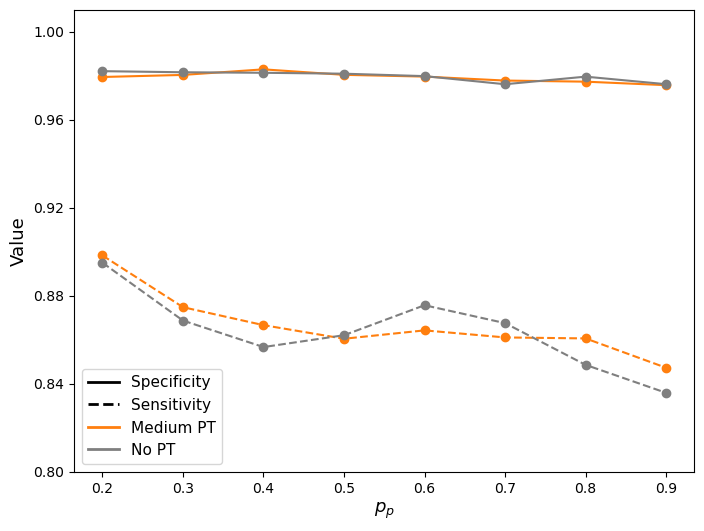

In [11]:
mask_probs = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
medium_sensitivities = []
medium_specificities = []
medium_F1_scores = []
naive_sensitivities = []
naive_specificities = []
naive_F1_scores = []
for i in range(len(mask_probs)):
    medium_results = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', f'FT_mediumPT_0.5_{mask_probs[i]}', 'results.pkl'))
    best_epoch = medium_results['best_epoch']
    medium_sensitivities.append(get_sensitivities(medium_results))
    medium_specificities.append(get_specificities(medium_results))
    medium_F1_scores.append(get_F1_scores(medium_results))
    
    naive_results = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', f'FT_naive_0.5_{mask_probs[i]}', 'results.pkl'))
    best_epoch = naive_results['best_epoch']
    naive_sensitivities.append(get_sensitivities(naive_results))
    naive_specificities.append(get_specificities(naive_results))
    naive_F1_scores.append(get_F1_scores(naive_results))
    

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(mask_probs, medium_specificities, "-o", color='tab:orange', label='Medium PT')
ax.plot(mask_probs, naive_specificities, "-o", color='tab:gray', label='No PT')
ax.plot(mask_probs, medium_sensitivities, "--o", color='tab:orange', label='Medium PT (sensitivity)')
ax.plot(mask_probs, naive_sensitivities, "--o", color='tab:gray', label='No PT (sensitivity)')

ax.set_xlabel(r'$p_p$', fontsize=13)
ax.set_ylabel('Value', fontsize=13)
ax.set_ylim(0.8, 1.01)

spec_line = Line2D([0], [0], color='black', linestyle='-', label='Specificity', lw=2)
sens_line = Line2D([0], [0], color='black', linestyle='--', label='Sensitivity', lw=2)
medium_line = Line2D([0], [0], color='tab:orange', linestyle='-', label='Medium PT', lw=2)
naive_line = Line2D([0], [0], color='tab:gray', linestyle='-', label='No PT', lw=2)
ax.legend(handles=[spec_line, sens_line, medium_line, naive_line], fontsize=11)
ax.set_yticks(np.arange(0.8, 1.01, 0.04))
plt.savefig(os.path.join(BASE_DIR, 'results', 'halftime_figs', 'sens_spec_vs_prob.png'), bbox_inches='tight', dpi=300, transparent=True)
plt.show()

### Slide 14 - F1 scores / F1 scores and sensitivity

C:\Users\jespe\AppData\Local\Temp\ipykernel_8268\2123941593.py:2: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(mask_probs, medium_F1_scores, "-o", color='tab:orange', label='Medium PT', linestyle='dotted')
C:\Users\jespe\AppData\Local\Temp\ipykernel_8268\2123941593.py:3: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(mask_probs, naive_F1_scores, "-o", color='tab:gray', label='No PT', linestyle='dotted')


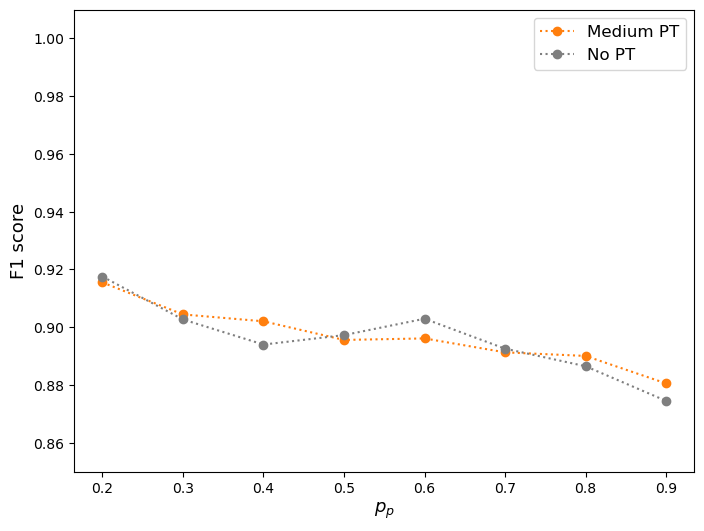

In [12]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(mask_probs, medium_F1_scores, "-o", color='tab:orange', label='Medium PT', linestyle='dotted')
ax.plot(mask_probs, naive_F1_scores, "-o", color='tab:gray', label='No PT', linestyle='dotted')

ax.set_xlabel(r'$p_p$', fontsize=13)
ax.set_ylabel('F1 score', fontsize=13)
ax.set_ylim(0.85, 1.01)

ax.legend(fontsize=12)
plt.savefig(os.path.join(BASE_DIR, 'results', 'halftime_figs', 'F1_vs_probs.png'), bbox_inches='tight', dpi=300, transparent=True)
plt.show()

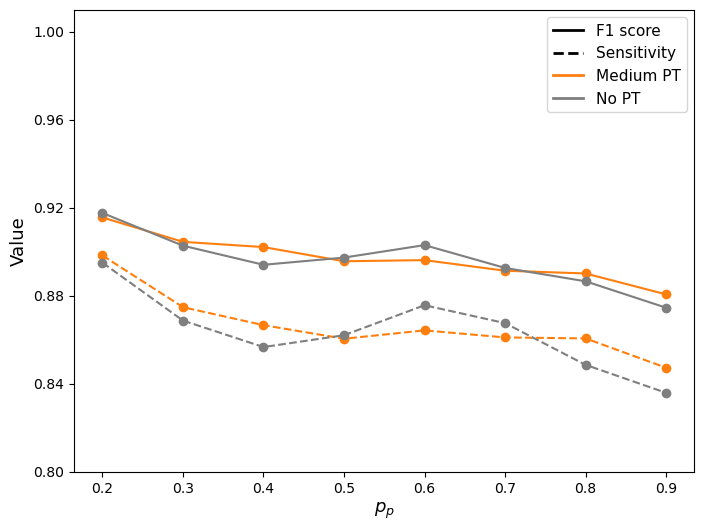

In [13]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(mask_probs, medium_F1_scores, "-o", color='tab:orange', label='Medium PT')
ax.plot(mask_probs, naive_F1_scores, "-o", color='tab:gray', label='No PT')
ax.plot(mask_probs, medium_sensitivities, "--o", color='tab:orange', label='Medium PT (sensitivity)')
ax.plot(mask_probs, naive_sensitivities, "--o", color='tab:gray', label='No PT (sensitivity)')

ax.set_xlabel(r'$p_p$', fontsize=13)
ax.set_ylabel('Value', fontsize=13)
ax.set_ylim(0.8, 1.01)

spec_line = Line2D([0], [0], color='black', linestyle='-', label='F1 score', lw=2)
sens_line = Line2D([0], [0], color='black', linestyle='--', label='Sensitivity', lw=2)
medium_line = Line2D([0], [0], color='tab:orange', linestyle='-', label='Medium PT', lw=2)
naive_line = Line2D([0], [0], color='tab:gray', linestyle='-', label='No PT', lw=2)
ax.legend(handles=[spec_line, sens_line, medium_line, naive_line], fontsize=11)
ax.set_yticks(np.arange(0.8, 1.01, 0.04))
plt.savefig(os.path.join(BASE_DIR, 'results', 'halftime_figs', 'sens_F1_vs_prob.png'), bbox_inches='tight', dpi=300, transparent=True)
plt.show()

### Slide 15 - Antibiotic level

Compare metrics for different pre-training regimes for each antibiotic

#### 60% genotypes masked, 80% phenotypes

#### 60% phenotypes masked, 1 known antibiotic

In [14]:
results_naive = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_naive_0.6_1known', 'results.pkl'))
results_easyPT = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_easyPT_0.6_1known', 'results.pkl'))
results_mediumPT = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_mediumPT_0.6_1known', 'results.pkl'))
results_hardPT = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_hardPT_0.6_1known', 'results.pkl'))
results_dicts = [results_naive, results_easyPT, results_mediumPT, results_hardPT]
model_names = ['No PT', 'Easy PT', 'Medium PT', 'Hard PT']

In [15]:
def get_sensitivities(results_dicts):
    sensitivities = []
    for results in results_dicts:
        ab_stats = results['val_ab_stats']
        sensitivities.append(ab_stats['num_correct_R'].sum() / ab_stats['num_R'].sum())
    return sensitivities

def get_specificities(results_dicts):
    specificities = []
    for results in results_dicts:
        ab_stats = results['val_ab_stats']
        specificities.append(ab_stats['num_correct_S'].sum() / ab_stats['num_S'].sum())
    return specificities

def get_F1_scores(results_dicts):
    F1_scores = []
    for results in results_dicts:
        ab_stats = results['val_ab_stats']
        sensitivity = ab_stats['num_correct_R'].sum() / ab_stats['num_R'].sum()
        precision = ab_stats['num_correct_R'].sum() / ab_stats['num_pred_R'].sum()
        F1_scores.append(2 * sensitivity * precision / (sensitivity + precision))
    return F1_scores

In [16]:
sensitivities = get_sensitivities(results_dicts)
specificities = get_specificities(results_dicts)
F1_scores = get_F1_scores(results_dicts)
ab_stats_list = [results['val_ab_stats'] for results in results_dicts]
ab_stats_list = [ab_stats.set_index('antibiotic') for ab_stats in ab_stats_list]
ab_stats_list = [ab_stats[ab_stats['num_tot'] > 20] for ab_stats in ab_stats_list]

Accuracy

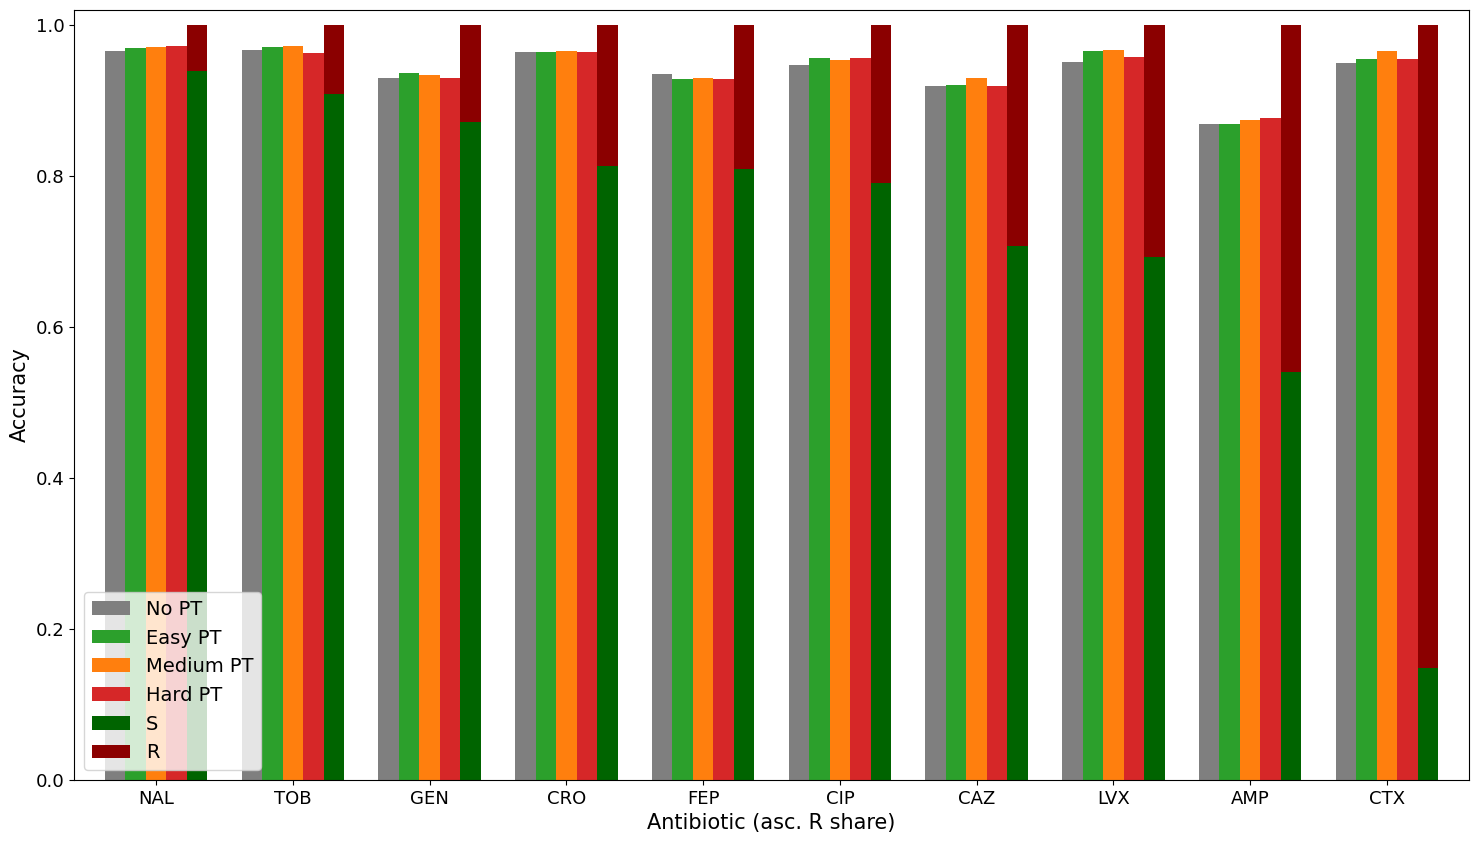

In [17]:
for ab_stats in ab_stats_list:
    ab_stats['frac_S'] = ab_stats['num_S'] / ab_stats['num_tot']
    ab_stats['frac_R'] = ab_stats['num_R'] / ab_stats['num_tot']
    ab_stats.sort_values(by='frac_S', inplace=True, ascending=False)
    # ab_stats['ME'] = 1 - ab_stats['specificity']
    # ab_stats['VME'] = 1 - ab_stats['sensitivity']
frac_S = ab_stats_list[0]['frac_S']
frac_R = ab_stats_list[0]['frac_R']

fig, ax = plt.subplots(figsize=(18, 10))
ind = np.arange(len(ab_stats_list[0]))
bar_width = 0.15
bar1 = ax.bar(ind - 2*bar_width, ab_stats_list[0]['accuracy'], width=bar_width, color='tab:gray', label='No PT')
bar2 = ax.bar(ind - bar_width, ab_stats_list[1]['accuracy'], width=bar_width, color='tab:green', label='Easy PT')
bar3 = ax.bar(ind, ab_stats_list[2]['accuracy'], width=bar_width, color='tab:orange', label='Medium PT')
bar4 = ax.bar(ind + bar_width, ab_stats_list[3]['accuracy'], width=bar_width, color='tab:red', label='Hard PT')
bar5_1 = ax.bar(ind + 2*bar_width, frac_S, width=bar_width, color='darkgreen', label='S')
bar5_2 = ax.bar(ind + 2*bar_width, frac_R, bottom=frac_S, width=bar_width, color='darkred', label='R')

ax.set_xlabel('Antibiotic (asc. R share)', fontsize=15)
ax.set_ylabel('Accuracy', fontsize=15)
ax.set_ylim(0, 1.02)
ax.set_xticks(ind, ab_stats_list[0].index)
ax.set_xticklabels(ab_stats_list[0].index, fontsize=13)
ax.tick_params(axis='y', labelsize=13)
ax.set_xlim(-0.6, len(ab_stats_list[0]) - 0.4)
ax.legend(loc='lower left', fontsize=14)
plt.savefig(os.path.join(BASE_DIR, 'results', 'halftime_figs', 'accs_vs_ab.png'), bbox_inches='tight', dpi=300, transparent=True)
plt.show()

Sensitivity

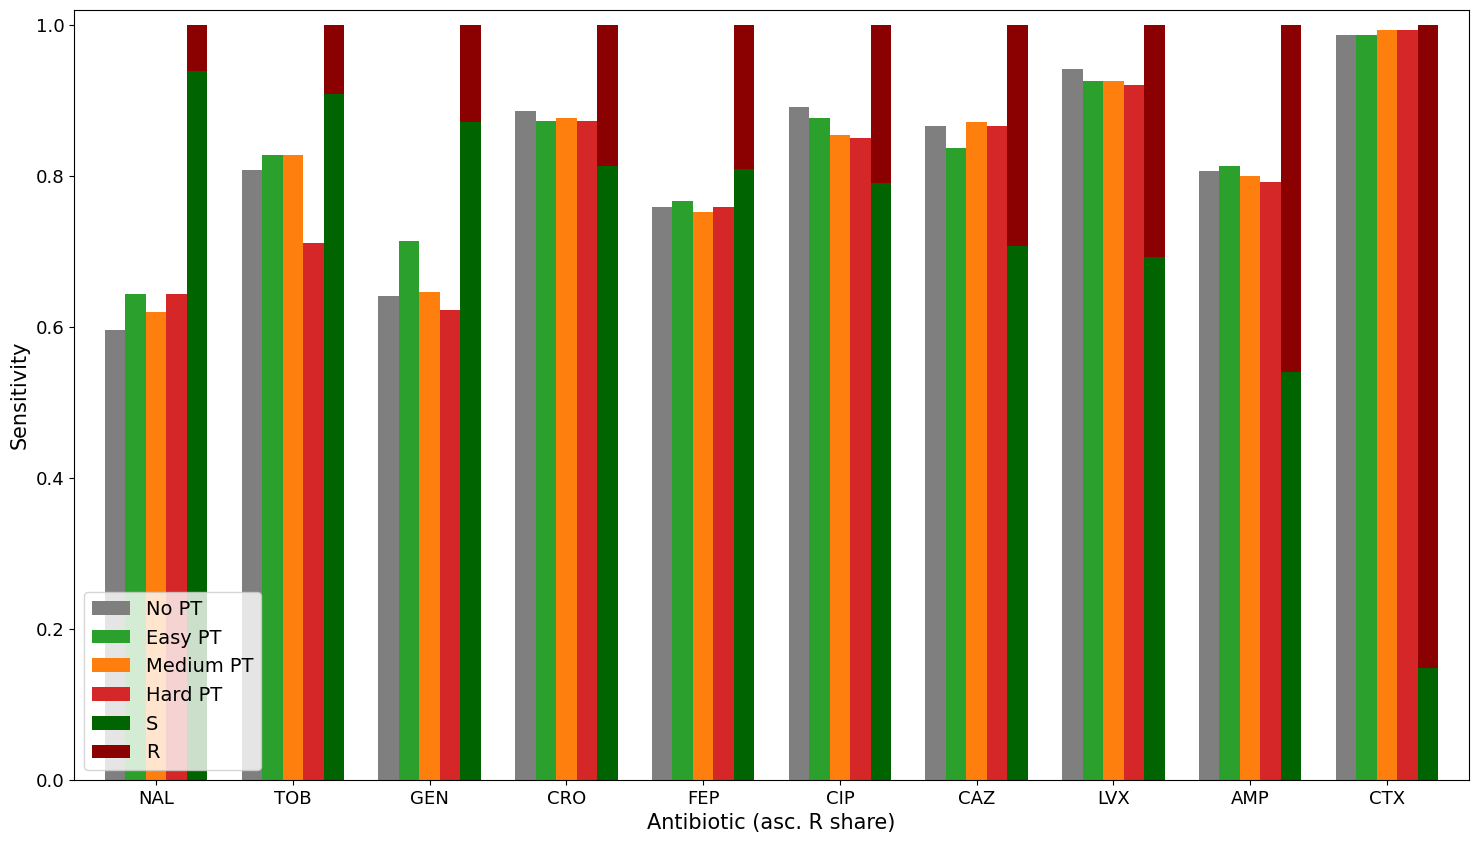

In [18]:
fig, ax = plt.subplots(figsize=(18, 10))
ind = np.arange(len(ab_stats_list[0]))
bar_width = 0.15
bar1 = ax.bar(ind - 2*bar_width, ab_stats_list[0]['sensitivity'], width=bar_width, color='tab:gray', label='No PT')
bar2 = ax.bar(ind - bar_width, ab_stats_list[1]['sensitivity'], width=bar_width, color='tab:green', label='Easy PT')
bar3 = ax.bar(ind, ab_stats_list[2]['sensitivity'], width=bar_width, color='tab:orange', label='Medium PT')
bar4 = ax.bar(ind + bar_width, ab_stats_list[3]['sensitivity'], width=bar_width, color='tab:red', label='Hard PT')
bar5_1 = ax.bar(ind + 2*bar_width, frac_S, width=bar_width, color='darkgreen', label='S')
bar5_2 = ax.bar(ind + 2*bar_width, frac_R, bottom=frac_S, width=bar_width, color='darkred', label='R')

ax.set_xlabel('Antibiotic (asc. R share)', fontsize=15)
ax.set_ylabel('Sensitivity', fontsize=15)
ax.set_ylim(0, 1.02)
ax.set_xticks(ind, ab_stats_list[0].index)
ax.set_xticklabels(ab_stats_list[0].index, fontsize=13)
ax.tick_params(axis='y', labelsize=13)
ax.set_xlim(-0.6, len(ab_stats_list[0]) - 0.4)
ax.legend(loc='lower left', fontsize=14)
plt.savefig(os.path.join(BASE_DIR, 'results', 'halftime_figs', 'sens_vs_ab.png'), bbox_inches='tight', dpi=300, transparent=True)
plt.show()

Specificity

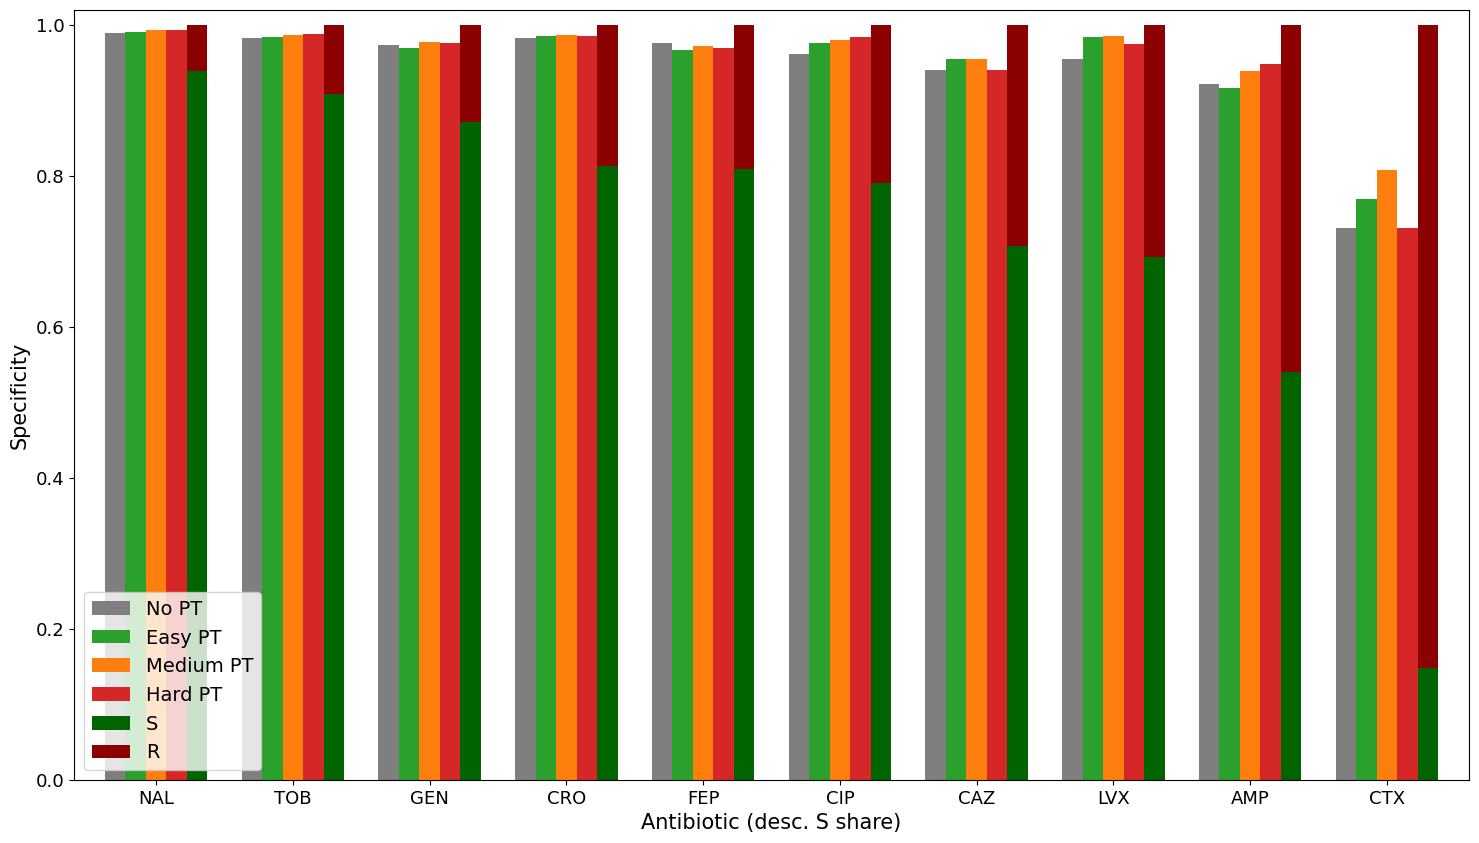

In [19]:
fig, ax = plt.subplots(figsize=(18, 10))
ind = np.arange(len(ab_stats_list[0]))
bar_width = 0.15
bar1 = ax.bar(ind - 2*bar_width, ab_stats_list[0]['specificity'], width=bar_width, color='tab:gray', label='No PT')
bar2 = ax.bar(ind - bar_width, ab_stats_list[1]['specificity'], width=bar_width, color='tab:green', label='Easy PT')
bar3 = ax.bar(ind, ab_stats_list[2]['specificity'], width=bar_width, color='tab:orange', label='Medium PT')
bar4 = ax.bar(ind + bar_width, ab_stats_list[3]['specificity'], width=bar_width, color='tab:red', label='Hard PT')
bar5_1 = ax.bar(ind + 2*bar_width, frac_S, width=bar_width, color='darkgreen', label='S')
bar5_2 = ax.bar(ind + 2*bar_width, frac_R, bottom=frac_S, width=bar_width, color='darkred', label='R')

ax.set_xlabel('Antibiotic (desc. S share)', fontsize=15)
ax.set_ylabel('Specificity', fontsize=15)
ax.set_ylim(0, 1.02)
ax.set_xticks(ind, ab_stats_list[0].index)
ax.set_xticklabels(ab_stats_list[0].index, fontsize=13)
ax.tick_params(axis='y', labelsize=13)
ax.set_xlim(-0.6, len(ab_stats_list[0]) - 0.4)
ax.legend(loc='lower left', fontsize=14)
plt.savefig(os.path.join(BASE_DIR, 'results', 'halftime_figs', 'spec_vs_ab.png'), bbox_inches='tight', dpi=300, transparent=True)
plt.show()

F1 Score

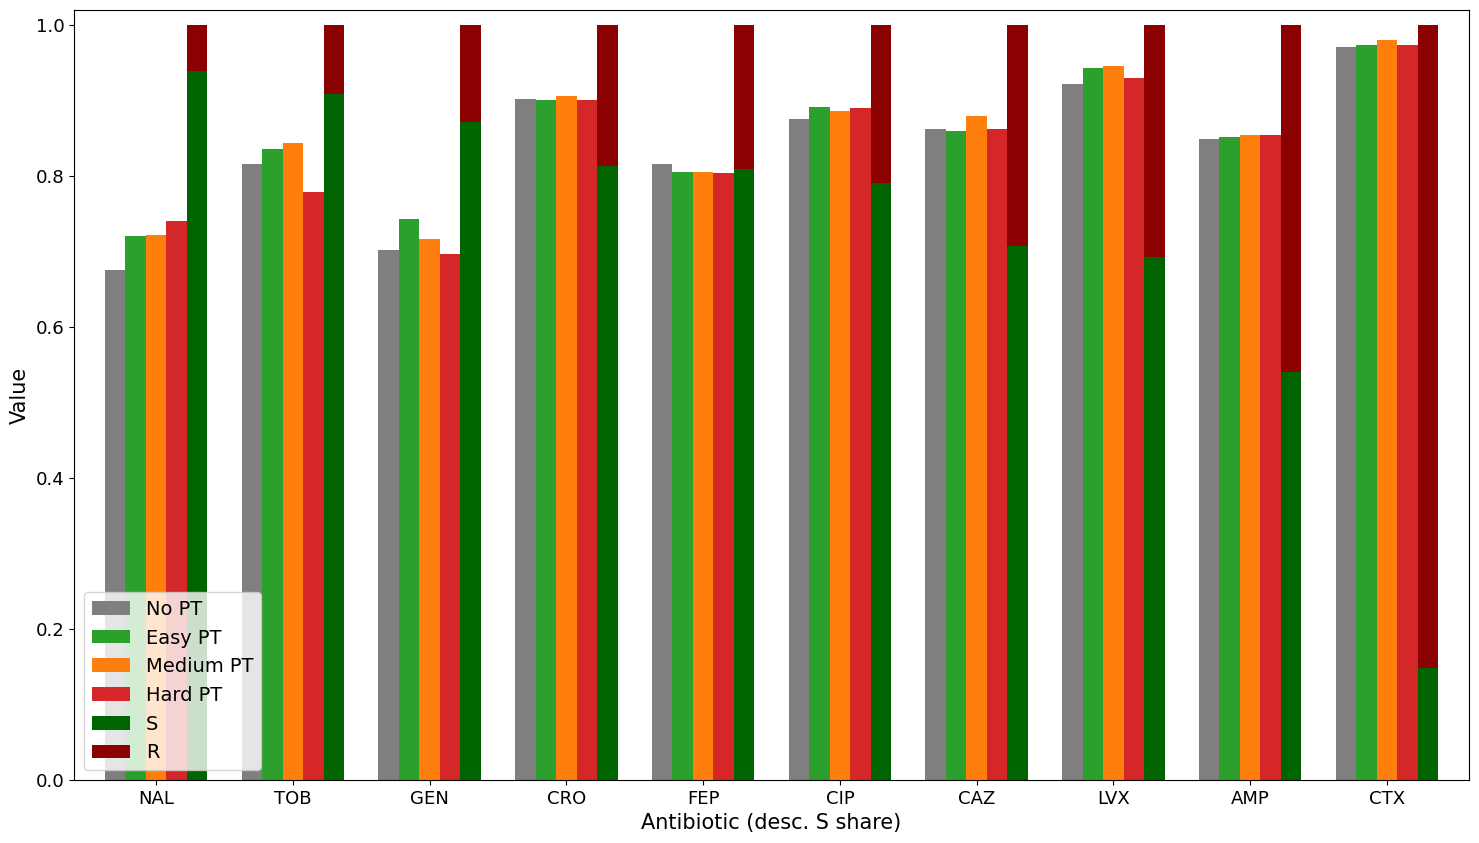

In [20]:
fig, ax = plt.subplots(figsize=(18, 10))
ind = np.arange(len(ab_stats_list[0]))
bar_width = 0.15
bar1 = ax.bar(ind - 2*bar_width, ab_stats_list[0]['F1'], width=bar_width, color='tab:gray', label='No PT')
bar2 = ax.bar(ind - bar_width, ab_stats_list[1]['F1'], width=bar_width, color='tab:green', label='Easy PT')
bar3 = ax.bar(ind, ab_stats_list[2]['F1'], width=bar_width, color='tab:orange', label='Medium PT')
bar4 = ax.bar(ind + bar_width, ab_stats_list[3]['F1'], width=bar_width, color='tab:red', label='Hard PT')
bar5_1 = ax.bar(ind + 2*bar_width, frac_S, width=bar_width, color='darkgreen', label='S')
bar5_2 = ax.bar(ind + 2*bar_width, frac_R, bottom=frac_S, width=bar_width, color='darkred', label='R')

ax.set_xlabel('Antibiotic (desc. S share)', fontsize=15)
ax.set_ylabel('Value', fontsize=15)
ax.set_ylim(0, 1.02)
ax.set_xticks(ind, ab_stats_list[0].index)
ax.set_xticklabels(ab_stats_list[0].index, fontsize=13)
ax.tick_params(axis='y', labelsize=13)
ax.set_xlim(-0.6, len(ab_stats_list[0]) - 0.4)
ax.legend(loc='lower left', fontsize=14)
plt.savefig(os.path.join(BASE_DIR, 'results', 'halftime_figs', 'F1_vs_ab.png'), bbox_inches='tight', dpi=300, transparent=True)
plt.show()

### Antibiotic distributions

In [21]:
df_TESSy = pd.read_pickle(os.path.join(BASE_DIR, 'data', 'TESSy.pkl'))
df_NCBI = pd.read_pickle(os.path.join(BASE_DIR, 'data', 'NCBI.pkl'))

In [22]:
antibiotics = df_TESSy['phenotypes'].apply(lambda x: [p.split('_')[0] for p in x]).explode()

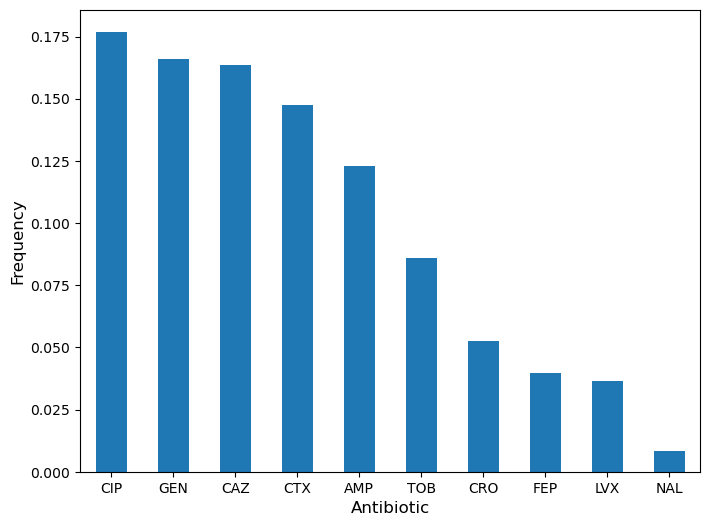

In [23]:
antibiotics.value_counts(normalize=True).plot.bar(
    figsize=(8, 6), rot=0, color='tab:blue' 
)
plt.xlabel('Antibiotic', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.savefig(os.path.join(BASE_DIR, 'results', 'halftime_figs', 'ab_freqs_TESSy.png'), bbox_inches='tight', dpi=300, transparent=True)
plt.show()

In [24]:
df_MM = df_NCBI[df_NCBI['num_ab'] > 0].reset_index(drop=True)
df_MM.head()

,year,country,genotypes,phenotypes,num_ab,num_genotypes,num_point_mutations
0,2013,USA,"[parC_S80I=POINT, aph(6)-Id, glpT_E448K=POINT,...","[AMP_R, FEP_R, CAZ_R, CRO_R, CIP_R, GEN_S, LVX...",8.0,18,9
1,2014,USA,"[parC_S80I=POINT, aph(6)-Id, glpT_E448K=POINT,...","[AMP_R, CTX_R, CAZ_R, CRO_R, CIP_R, GEN_S, LVX...",8.0,21,9
2,2012,USA,"[sul2, aph(6)-Id, glpT_E448K=POINT, pmrB_Y358N...","[AMP_R, CRO_S, CIP_S, GEN_S, NAL_S]",5.0,8,2
3,2012,USA,"[sul2, aph(6)-Id, glpT_E448K=POINT, pmrB_Y358N...","[AMP_R, CRO_S, CIP_S, GEN_S, NAL_S]",5.0,8,2
4,2012,USA,"[sul1, tet(A), aph(3')-Ia=PARTIAL_END_OF_CONTI...","[AMP_S, CRO_S, CIP_S, GEN_S, NAL_S]",5.0,6,0


In [25]:
antibiotics = df_MM['phenotypes'].apply(lambda x: [p.split('_')[0] for p in x]).explode()

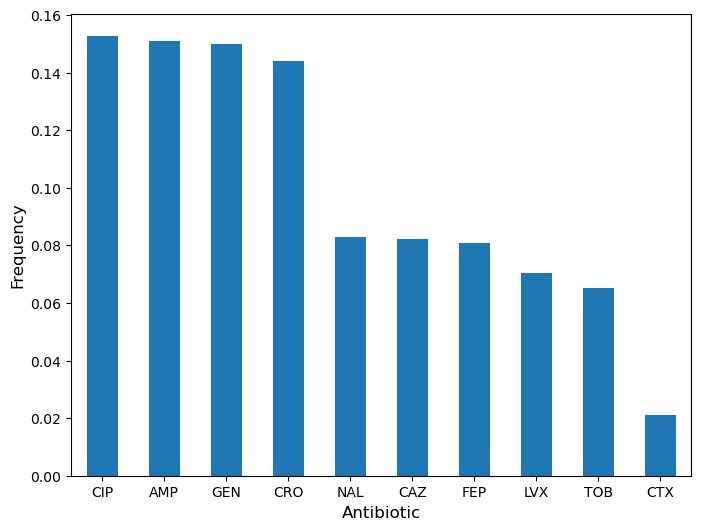

In [26]:
antibiotics.value_counts(normalize=True).plot.bar(
    figsize=(8, 6), rot=0, color='tab:blue' 
)
plt.xlabel('Antibiotic', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.savefig(os.path.join(BASE_DIR, 'results', 'halftime_figs', 'ab_freqs_NCBI.png'), bbox_inches='tight', dpi=300, transparent=True)
plt.show()

In [40]:
ab_pheno = df_MM['phenotypes'].explode().reset_index(drop=True)
df = pd.DataFrame(ab_pheno.str.split('_').tolist(), columns=['ab', 'pheno'])
df.set_index('ab', inplace=True)
df

,pheno
ab,
AMP,R
FEP,R
CAZ,R
CRO,R
CIP,R
...,...
CRO,R
CIP,S
GEN,S


pheno     S     R   S_share   R_share
ab                                   
GEN    5257   779  0.130635  0.019358
CIP    4992  1156  0.124050  0.028726
CRO    4711  1081  0.117067  0.026862
AMP    3273  2803  0.081333  0.069652
NAL    3110   229  0.077282  0.005690
FEP    2641   604  0.065628  0.015009
TOB    2394   233  0.059490  0.005790
CAZ    2378   933  0.059092  0.023184
LVX    1990   836  0.049451  0.020774
CTX     134   708  0.003330  0.017593


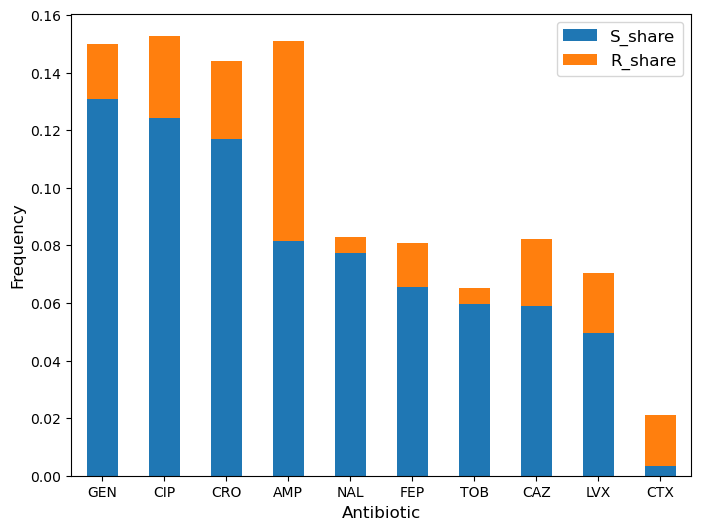

In [63]:
ab_pheno_counts = df.groupby(['ab', 'pheno']).size().unstack()
ab_pheno_counts = ab_pheno_counts[['S', 'R']]
ab_pheno_counts['S_share'] = ab_pheno_counts['S'] / (ab_pheno_counts.sum().sum())
ab_pheno_counts['R_share'] = ab_pheno_counts['R'] / (ab_pheno_counts.sum().sum())
ab_pheno_counts.sort_values(by='S_share', inplace=True, ascending=False)
print(ab_pheno_counts)
fig, ax = plt.subplots(figsize=(8, 6))
ax = ab_pheno_counts[['S_share', 'R_share']].plot.bar(stacked=True, rot=0, ax=ax)
ax.set_xlabel('Antibiotic', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.legend(loc='upper right', fontsize=12)
plt.show()

pheno     S     R   S_share   R_share
ab                                   
GEN    5257   779  0.870941  0.129059
CIP    4992  1156  0.811971  0.188029
CRO    4711  1081  0.813363  0.186637
AMP    3273  2803  0.538677  0.461323
NAL    3110   229  0.931417  0.068583
FEP    2641   604  0.813867  0.186133
TOB    2394   233  0.911306  0.088694
CAZ    2378   933  0.718212  0.281788
LVX    1990   836  0.704176  0.295824
CTX     134   708  0.159145  0.840855


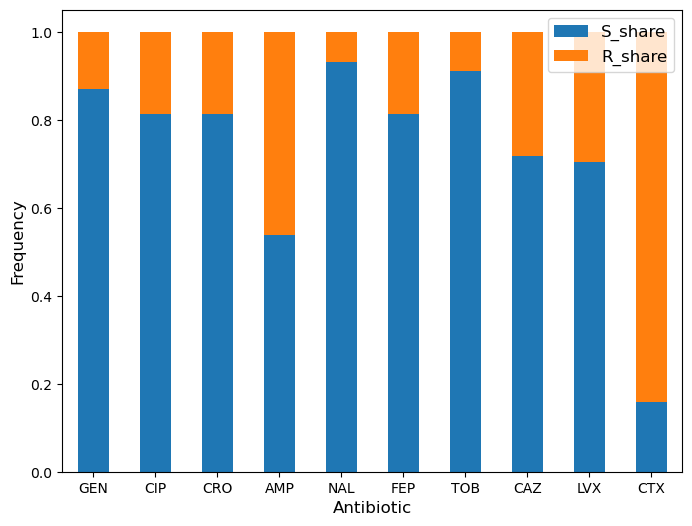

In [57]:
ab_pheno_counts = df.groupby(['ab', 'pheno']).size().unstack()
ab_pheno_counts = ab_pheno_counts[['S', 'R']]
ab_pheno_counts['S_share'] = ab_pheno_counts['S'] / (ab_pheno_counts['S'] + ab_pheno_counts['R'])
ab_pheno_counts['R_share'] = ab_pheno_counts['R'] / (ab_pheno_counts['S'] + ab_pheno_counts['R'])
ab_pheno_counts.sort_values(by='S', inplace=True, ascending=False)
print(ab_pheno_counts)
fig, ax = plt.subplots(figsize=(8, 6))
ax = ab_pheno_counts[['S_share', 'R_share']].plot.bar(stacked=True, rot=0, ax=ax)
ax.set_xlabel('Antibiotic', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.legend(loc='upper right', fontsize=12)
plt.show()